<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Flag_of_India.svg/320px-Flag_of_India.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition indienne du *Huff Post* (2014-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Inde"
huff = huff[huff.pays == edition]
huff.shape

(14618, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

Huffington Post India             14575
The Times of India                16   
The Indian Express                7    
http://www.hindustantimes.com/    4    
The News Minute                   4    
Firstpost                         3    
NDTV.com                          2    
The Huffington Post               2    
reddit                            1    
Gadget Now                        1    
dna                               1    
The Economic Times                1    
The Hindu                         1    
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

Huffington Post India    14575
The Huffington Post      2    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(14577, 13)

In [7]:
len(huff) - len(huff[metaHP])

41

Le calcul ci-haut nous indique qu'on a **41 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? ?                                                                                                                                                                       2851
? PTI                                                                                                                                                                     1967
Adrija Bose Social Media Editor                                                                                                                                           760 
Ivan Mehta Tech News Editor                                                                                                                                               668 
Aashmita Nayar Lifestyle editor, HuffPost India                                                                                                                           659 
Prajakta Hebbar News Producer, HuffPost India                                                                                

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent quand même près de **20%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(2851, 19.503352031741688)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(5642, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(Aashmita Nayar Lifestyle editor, HuffPost India                                        659
 Prajakta Hebbar News Producer, HuffPost India                                          635
 Betwa Sharma Politics Editor, HuffPost India                                           598
 Rituparna Chatterjee Front page editor, HuffPost India                                 558
 Indrani Basu News Editor, HuffPost India                                               542
 Piyasree Dasgupta Features Editor, HuffPost India                                      263
 Naina Chaturvedi Editorial Producer, HuffPost India                                    258
 Anurag Verma Trends Editor,  HuffPost India                                            238
 Anirvan Ghosh Business editor, HuffPost India                                          185
 Jacob Koshy Business Editor, HuffPost India                                            166
 Shivam Vij Deputy Editor, HuffPost India                                       

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **5&nbsp;642 articles** signés par **224 signataires différents**.<br>
Cela représente plus du tiers de l'ensemble des articles publiés par l'édition indienne du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(5642, 38.596251197154189)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(8935, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(? ?                                                                                                                                                                       2851
 ? PTI                                                                                                                                                                     1967
 Adrija Bose Social Media Editor                                                                                                                                           760 
 Ivan Mehta Tech News Editor                                                                                                                                               668 
 Suprateek Chatterjee Entertainment Editor                                                                                                                                 617 
 ? ANI                                                                                                                  

Des 123 signataires ci-dessus, par contre, on trouve plusieurs «&nbsp;employés fantôme&nbsp;». Ils comprennent, dans leur signature, les mots *«&nbsp;editor&nbsp;»*, *«&nbsp;correspondent&nbsp;»*, *«&nbsp;producer&nbsp;»* ou *«&nbsp;reporter&nbsp;»*, par exemples.
Isolons-les.

In [15]:
fantomes = huff[metaHP][NONsigneHP].byline.str.contains("[E,e]ditor|[C,c]orrespondent|[P,p]roducer|[R,r]eporte")
huff[metaHP][NONsigneHP][fantomes].byline.value_counts(), huff[metaHP][NONsigneHP][fantomes].byline.value_counts().sum()

(Adrija Bose Social Media Editor                                                                     760
 Ivan Mehta Tech News Editor                                                                         668
 Suprateek Chatterjee Entertainment Editor                                                           617
 Ankur Pathak Bollywood Editor                                                                       369
 Rimin Dutt Business Editor                                                                          170
 Vyas Mohan Evening Editor                                                                           168
 Sonam Joshi Lifestyle Editor                                                                        80 
 Sudhi Ranjan Sen Deputy Editor (News)                                                               27 
 Rukmini S Editor, Data & Innovation                                                                 19 
 Anahita Khanna Editorial Fellow                       

Il y a donc 2&nbsp;971 articles qui ont été écrits par des employés du *HuffPost* ou des pigistes. On peut les ajouter à notre variable `HP_oui`.

In [16]:
HP_oui = huff[metaHP][signeHP].pays.count() + 2971
HP_oui, (HP_oui/len(huff))*100

(8613, 58.920508961554255)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, additionner les articles qu'on a identifiés plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, et retrancher les articles qu'on vient d'ajouter à notre variable `HP_oui`.

In [17]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 2971
HP_non, (HP_non/len(huff))*100

(3154, 21.576139006704064)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

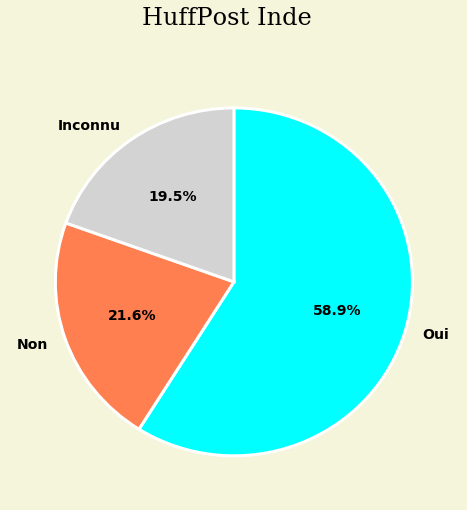

In [18]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Inde", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [19]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

in-news                                                    7432
news                                                       7306
News                                                       2695
in-politics                                                2092
politics                                                   1965
entertainment                                              1699
in-entertainment                                           1652
Politics                                                   795 
india                                                      725 
in-lifestyle                                               720 
lifestyle                                                  664 
bollywood                                                  661 
Entertainment                                              645 
in-business                                                623 
Narendra Modi                                              577 
tech                                    